In [52]:
import cv2 as cv
import glob, json
import numpy as np
import faiss, glob, os
import tensorflow as tf
from deepface import DeepFace
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageFont

In [63]:
models = [
        "VGG-Face", 
        "Facenet", 
        "Facenet512", 
        "OpenFace", 
        "DeepFace", 
        "DeepID", 
        "ArcFace", 
        "Dlib", 
        "SFace",
        "GhostFaceNet",
        ]

In [64]:
def create_dataset(
                data_dir = "data/facedb/*/*.*",
                json_dir = "data/facedb_jsons/{}/{}",
                ):
    for img_path in glob.glob(data_dir):
        person_objs = []
        img_path = img_path.replace("\\", "/")
        person_name = img_path.split("/")[-2]
        file_name = img_path.split("/")[-1]
        face_objs = DeepFace.represent(
                                    img_path = img_path,
                                    model_name = "Facenet512",
                                    enforce_detection = False
                                    )
        if len(face_objs) > 0:
            for i in range(len(face_objs)):
                person_json = {}
                facial_area = face_objs[i]['facial_area']
                x, y, w, h = facial_area['x'], facial_area['y'], facial_area['w'], facial_area['h']
                person_json['person_name'] = person_name
                person_json['facial_area'] = facial_area
                person_json['file_name'] = file_name
                person_json['coor'] = (x, y, w, h)
                person_objs.append(person_json)

        if len(person_objs) > 0:
            os.makedirs(json_dir.format(person_name, ""), exist_ok=True)
            json_file = json_dir.format(person_name, file_name.replace(".jpg", ".json"))
            with open(json_file, 'w') as json_file:
                json.dump(person_objs, json_file)

In [65]:
create_dataset()

### Detection Model

In [66]:
def load_detection_dataset(
                            data_dir = "data/facedb/*/*.*"
                            ):
    X, Y = [], []
    for img_path in glob.glob(data_dir):
        json_path = img_path.replace("\\", "/").replace("facedb", "facedb_jsons").replace(".jpg", ".json")
        if (os.path.exists(json_path)):
            with open(json_path, 'r') as json_file:
                json_data = json.load(json_file)
                person = json_data[0]
                x, y, w, h = person['coor']
                img = cv.imread(img_path)
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                img = cv.resize(img, (128, 128))

                X.append(img)
                Y.append((x, y, w, h))

    return np.array(X), np.array(Y)

In [67]:
X, Y = load_detection_dataset() 

print("Image Shape: ", X.shape)
print("Label Shape: ", Y.shape)

Image Shape:  (405, 128, 128, 3)
Label Shape:  (405, 4)


In [68]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
                                    tf.keras.layers.MaxPooling2D((2, 2)),
                                    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D((2, 2)),
                                    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(64, activation='relu'),
                                    tf.keras.layers.Dense(4)
                                    ])

model.compile(
                optimizer='adam', 
                loss='mean_squared_error', 
                metrics=['mae']
                )
model.fit(
        X, Y, 
        epochs=200
        )

Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - loss: 232522.1719 - mae: 344.5006
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - loss: 84675.9766 - mae: 190.3952
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - loss: 83003.2891 - mae: 192.4763
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - loss: 76297.2188 - mae: 181.0720
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - loss: 77168.1797 - mae: 184.3297
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - loss: 67504.3906 - mae: 179.4448
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - loss: 59226.5664 - mae: 164.4039
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - loss: 50572.7266 - mae: 151.6991
Epoch 9/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - loss: 42191.7500 - mae: 133.3880
Epoch 10/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - loss: 25960.8047 - mae: 114.5123
Epoch 11/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - loss: 20238.4121 - mae: 99.7550
Epoch 12/200
13/13 ━━━━━━━━━━━

In [69]:
def visualize_face_detection(img_path):
    face_objs = DeepFace.represent(
                                img_path = img_path,
                                model_name = "Facenet512",
                                enforce_detection = False
                                )
    for i in range(len(face_objs)):
        facial_area = face_objs[i]['facial_area']
        face_confidence = face_objs[i]['face_confidence']
        x, y, w, h = facial_area['x'], facial_area['y'], facial_area['w'], facial_area['h']

        image = Image.open(img_path)
        draw = ImageDraw.Draw(image)
        draw.rectangle([x, y, x+w, y+h], outline='red', width=5)
        font = ImageFont.truetype("arial.ttf", 30)
        draw.text((x-30, y-40), f'Confidence: {face_confidence}', font=font, fill='blue')
        
    plt.imshow(image)


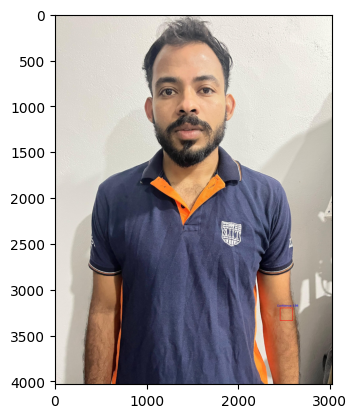

In [70]:
img_path = "data/facedb/purna/purna (4).jpg"
visualize_face_detection(img_path)

In [71]:
def extract_face_information_for_db(img_path):
    # face_objs = DeepFace.represent(
    #                                 img_path = img_path, 
    #                                 detector_backend = backends[4],
    #                                 align = alignment_modes[0],
    #                                 enforce_detection = False
    #                                 )
    face_objs = DeepFace.represent(
                                img_path = img_path,
                                model_name = models[2],
                                enforce_detection = False
                                )
    img_path = img_path.replace("\\", "/")
    user_name = img_path.split("/")[-2]

    if len(face_objs) != 1:
        if len(face_objs) == 0:
            Warning(f"No faces detected in the image : {img_path}")
        else:
            Warning(f"Multiple faces detected in the image : {img_path}")
        return None, None, None, None

    else:
        facial_area = face_objs[0]['facial_area']
        embeddings = face_objs[0]['embedding']
        face_confidence = face_objs[0]['face_confidence']
        x, y, w, h = facial_area['x'], facial_area['y'], facial_area['w'], facial_area['h']

    return embeddings, face_confidence, (x, y, w, h), user_name

def extract_face_information_for_inference(img_path):
    face_objs = DeepFace.represent(
                                img_path = img_path,
                                model_name = models[2],
                                enforce_detection = False
                                )
    img_path = img_path.replace("\\", "/")

    embeddings = []
    facial_areas = []
    face_confidences = []

    if len(face_objs) == 0:
        Warning(f"No faces detected in the image : {img_path}")
    else:
        for i in range(len(face_objs)):
            embs = face_objs[i]['embedding']
            facial_area = face_objs[i]['facial_area']
            face_confidence = face_objs[i]['face_confidence']
            x, y, w, h = facial_area['x'], facial_area['y'], facial_area['w'], facial_area['h']

            embeddings.append(embs)
            facial_areas.append((x, y, w, h))   
            face_confidences.append(face_confidence)

    return embeddings, face_confidences, facial_areas

In [72]:
def build_face_embedding_index(
                                d = 512,
                                face_index_path = 'models/face_index',
                                face_image_dir = 'data/facedb/*/*.jpg',
                                face_details_path = 'models/face_details.npz',
                                ):
    if (not os.path.exists(face_index_path)) or (not os.path.exists(face_details_path)):
        faiss_index = faiss.index_factory(d, "Flat", faiss.METRIC_INNER_PRODUCT)

        embeddings = []
        user_names = []
        facial_areas = []
        face_confidences = []
        
        for idx, img_path in enumerate(glob.glob(face_image_dir)):
            emb, face_confidence, facial_area, user_name = extract_face_information_for_db(img_path)
            if emb is not None:
                embeddings.append(emb)
                user_names.append(user_name)
                facial_areas.append(facial_area)
                face_confidences.append(face_confidence)

            if idx % 10 == 0:
                print(f"Processed {idx}/{len(glob.glob(face_image_dir))} images")

        embeddings = np.asarray(embeddings).astype('float32')
        faiss.normalize_L2(embeddings)
        faiss_index.add(embeddings)
        faiss.write_index(faiss_index, face_index_path)

        np.savez(
                face_details_path, 
                user_names=user_names, 
                facial_areas=facial_areas, 
                face_confidences=face_confidences
                )
        
    else:
        faiss_index = faiss.read_index(face_index_path)
        face_details = np.load(face_details_path)
        user_names = face_details['user_names']
        facial_areas = face_details['facial_areas']
        face_confidences = face_details['face_confidences']

    return faiss_index, user_names, facial_areas, face_confidences

In [73]:
index, user_names, facial_areas, face_confidences = build_face_embedding_index()

In [74]:
def add_user_to_db(
                    username, 
                    face_index_path = 'models/face_index',
                    face_details_path = 'models/face_details.npz',
                    face_image_dir = 'data/facedb/{}/*.jpg'
                    ):
    index, user_names, facial_areas, face_confidences = build_face_embedding_index(
                                                                                    face_index_path = face_index_path,
                                                                                    face_details_path = face_details_path,
                                                                                    )
    if username in user_names:
        Warning(f"User {username} already exists in the database")
        return
    
    user_names_to_add = []
    facial_areas_to_add = []
    face_confidences_to_add = []

    for img_path in glob.glob(face_image_dir.format(username)):
        emb, face_confidence, facial_area, user_name = extract_face_information_for_db(img_path)
        if emb is not None:
            embeddings = np.array([emb]).astype('float32')
            faiss.normalize_L2(embeddings)
            index.add(embeddings)
            user_names_to_add.append(user_name)
            facial_areas_to_add.append(facial_area)
            face_confidences_to_add.append(face_confidence)

    faiss.write_index(index, face_index_path)

    if len(user_names_to_add) > 0:
        user_names = np.concatenate([user_names, user_names_to_add])
        facial_areas = np.concatenate([facial_areas, facial_areas_to_add])
        face_confidences = np.concatenate([face_confidences, face_confidences_to_add])

    np.savez(
            face_details_path, 
            user_names=user_names, 
            facial_areas=facial_areas, 
            face_confidences=face_confidences
            )
    
    print(f"User : {username} added to the database")

def search_face_in_db(
                    img_path, 
                    face_index_path = 'models/face_index',
                    face_details_path = 'models/face_details.npz',
                    ):
    index, user_names, _, _ = build_face_embedding_index(
                                                        face_index_path = face_index_path,
                                                        face_details_path = face_details_path,
                                                        )
    embeddings, face_confidences, facial_areas = extract_face_information_for_inference(img_path)

    retrieved_user_names = []
    retrieved_facial_areas = []
    retrieved_face_confidences = []

    if embeddings is not None:
        for idx, emb in enumerate(embeddings):
            if face_confidences[idx] >= 0.8:
                emb = np.array(emb).reshape(1, -1).astype('float32')
                faiss.normalize_L2(emb)
                D, I = index.search(emb, 5)
                I = np.array(I).squeeze()
                D = np.array(D).squeeze()
                user_name_list = [user_names[i] for i in I]
                user_name = max(set(user_name_list), key = user_name_list.count)
                avg_confidence = np.mean([d for i, d in zip(I, D) if user_names[i] == user_name])
                retrieved_face_confidences.append(np.round(avg_confidence, 3))
                retrieved_facial_areas.append(facial_areas[idx])
                retrieved_user_names.append(user_name)

    return retrieved_user_names, retrieved_facial_areas, retrieved_face_confidences

def verify_and_visualize_user(  
                                username,
                                img_path,
                                ):
    retrieved_user_names, retrieved_facial_areas, retrieved_face_confidences = search_face_in_db(img_path)

    image = Image.open(img_path)
    draw = ImageDraw.Draw(image)

    for i in range(len(retrieved_user_names)):
        x, y, w, h = retrieved_facial_areas[i]
        face_area = w * h
        if (face_area >= 20000):
            if (retrieved_user_names[i] == username) and (retrieved_face_confidences[i] >= 0.5):
                draw.rectangle([x, y, x+w, y+h], outline='green', width=5)
                font = ImageFont.truetype("arial.ttf", 30)
                draw.text((x-30, y-70), f'User: {retrieved_user_names[i]}', font=font, fill='green')
            else:
                draw.rectangle([x, y, x+w, y+h], outline='red', width=5)
                font = ImageFont.truetype("arial.ttf", 30)

    plt.imshow(image)
    plt.show()

def verify_and_visualize_user_realtime(username):
    cap = cv.VideoCapture(0)
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        cv.imwrite("data/temp_dir/temp.jpg", frame)
        
        retrieved_user_names, retrieved_facial_areas, retrieved_face_confidences = search_face_in_db("data/temp_dir/temp.jpg")
        for i in range(len(retrieved_user_names)):
            x, y, w, h = retrieved_facial_areas[i]
            face_area = w * h
            if (face_area >= 20000):
                if (retrieved_user_names[i] == username) and (retrieved_face_confidences[i] >= 0.5):
                    cv.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
                    font = cv.FONT_HERSHEY_SIMPLEX
                    cv.putText(frame, f'User: {retrieved_user_names[i]}', (x-30, y-40), font, 1, (0, 255, 0), 2)
                else:
                    cv.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 2)

        cv.imshow('frame', frame)

        if cv.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv.destroyAllWindows()

In [75]:
add_user_to_db('purna')

User : purna added to the database


In [76]:
retrieved_user_names, retrieved_facial_areas, retrieved_face_confidences = search_face_in_db(img_path)

print(f"Retrieve User Names : {retrieved_user_names}")
print(f"Retrieve Face Confidences : {retrieved_face_confidences}")
print(f"Retrieve Facial Areas : {retrieved_facial_areas}")

Retrieve User Names : ['purna', 'Alia Bhatt', 'Amitabh Bachchan']
Retrieve Face Confidences : [0.841, 0.697, 0.712]
Retrieve Facial Areas : [(888, 377, 1121, 1121), (2868, 2149, 73, 73), (2446, 3201, 141, 141)]


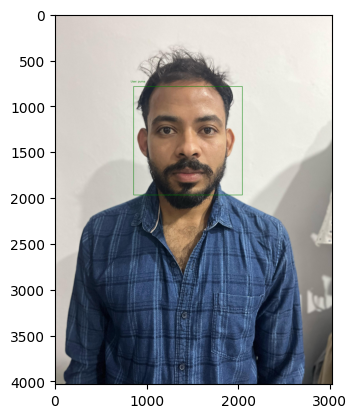

In [79]:
verify_and_visualize_user("purna", 'data/test_images/purna (11).jpg')

In [80]:
verify_and_visualize_user_realtime("purna")

KeyboardInterrupt: 